<a href="https://colab.research.google.com/github/richi1998/NLP-Project/blob/main/NLP_Assignment_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## For Colab users

Uncomment the following to install the Transformers library (only necessary if you solve the second optional task).

In [ ]:
import pandas as pd
import zipfile
import os

# Download the raw files from GitHub
!wget https://github.com/richi1998/NLP-Project/raw/main/ner_dataset.csv.zip -O ner_dataset.csv.zip



with zipfile.ZipFile('ner_dataset.csv.zip', 'r') as zip_ref:
    zip_ref.extractall()

# Check what files are in the directory
print("Files in the current directory:", os.listdir())

!pip install allennlp



--2024-01-08 09:28:35--  https://github.com/richi1998/NLP-Project/raw/main/ner_dataset.csv.zip
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/richi1998/NLP-Project/main/ner_dataset.csv.zip [following]
--2024-01-08 09:28:36--  https://raw.githubusercontent.com/richi1998/NLP-Project/main/ner_dataset.csv.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3319491 (3.2M) [application/zip]
Saving to: ‘ner_dataset.csv.zip’

ner_dataset.csv.zip 100%[===================>]   3.17M  --.-KB/s    in 0.04s   

2024-01-08 09:28:36 (74.9 MB/s) - ‘ner_dataset.csv.zip’ saved [3319491/3319491]

Files in the curr

In [ ]:
import pandas as pd

# Read the CSV files
# Replace 'file_name.csv' with the actual names of the extracted files

# df1 = pd.read_csv('ner.csv', error_bad_lines=False,  encoding='latin1')  # Adjust encoding if necessary
# df1 = df1.fillna(method='ffill')
df2 = pd.read_csv('ner_dataset.csv', encoding='latin1')  # Adjust encoding if necessary
df2 = df2.fillna(method='ffill')

# # Display the first few rows of the datasets
# print("First dataset:")
# print(df1.head())
print("\nSecond dataset:")
print(df2.head(5))
tags = list(set(df2['Tag'].values))#iob2 tags
num_tags = len(tags)
print("Number of different tags in dataset and their names:")
print(num_tags)
tag2idx = {t: i for i, t in enumerate(tags)}
print(*tag2idx, sep='\n')


Second dataset:
    Sentence #           Word  POS Tag
0  Sentence: 1      Thousands  NNS   O
1  Sentence: 1             of   IN   O
2  Sentence: 1  demonstrators  NNS   O
3  Sentence: 1           have  VBP   O
4  Sentence: 1        marched  VBN   O
Number of different tags in dataset and their names:
17
I-eve
I-nat
I-geo
I-art
B-art
I-per
B-geo
B-org
O
I-gpe
I-tim
B-nat
B-per
B-tim
B-eve
B-gpe
I-org


In [ ]:
!git clone https://github.com/richi1998/NLP-Project.git

%cd NLP-Project
import scrip_NER_NLP_project

fatal: destination path 'NLP-Project' already exists and is not an empty directory.
/content/NLP-Project


We get the helper Python file and the files containing the training and validation data.

In [ ]:
from sklearn.model_selection import train_test_split


train_df, val_df = train_test_split(df2, test_size=0.2, random_state=42, shuffle= False)

# Display the shape of the training and validation sets
print("Training set shape:", train_df.shape)
print("Validation set shape:", val_df.shape)


Training set shape: (838860, 4)
Validation set shape: (209715, 4)


In [ ]:
Xtrain, Ytrain = scrip_NER_NLP_project.read_data_from_dataframe(train_df)
Xval, Yval = scrip_NER_NLP_project.read_data_from_dataframe(val_df)

In [ ]:
Xtrain[38345]

['The',
 'United',
 'Nations',
 'is',
 'praising',
 'the',
 'use',
 'of',
 'military',
 'helicopters',
 'to',
 'drop',
 'food',
 'and',
 'rescue',
 'survivors',
 'in',
 'tsunami-ravaged',
 'Indonesia',
 ',',
 'saying',
 'the',
 'aircraft',
 'are',
 '"',
 'worth',
 'their',
 'weight',
 'in',
 'gold',
 '.',
 '"']

In [ ]:
Ytrain[38345]

['O',
 'B-org',
 'I-org',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-tim',
 'I-tim',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O']

## Baseline sequence labeling model

This is the baseline model. You can expand on this when implementing your solution.

In [ ]:
import torch
from torch import nn

class BaselineSequenceModel(nn.Module):

    def __init__(self, seq_labeler):
        super().__init__()

        # Here is how you access the NERParameters.
        p = seq_labeler.params

        # The model consists of just a word embedding layer and a
        # linear output unit. We use the vocabulary to create the embedding layer.
        self.word_embedding = seq_labeler.word_voc.make_embedding_layer(finetune=p.finetune_word_emb,
                                                                        emb_dim=p.word_emb_dim)

        # The dimensionality of the word embedding model.
        word_emb_dim = self.word_embedding.weight.shape[1]

        # Output unit.
        self.top_layer = nn.Linear(word_emb_dim, seq_labeler.n_labels)

    def forward(self, words):
        # words is a tensor of integer-encoded words, with shape (batch_size, max_sen_length)

        # After embedding the words, the shape is (batch_size, max_sen_length, emb_dim).
        word_repr = self.word_embedding(words)

        # We predict the BIO label simply by applying a linear model to
        # the word embedding at that position.

        # The shape of the output is (batch_size, max_sen_length, n_labels),
        # where n_labels is the size of the output label vocabulary.
        return self.top_layer(word_repr)

## Training the system

As usual, we create an object that contains all hyperparameters.

In [ ]:
class NERParameters:

    # Random seed, for reproducibility.
    random_seed = 0

    bert_max_len = 128
    # cuda or cpu
    device = 'cuda'

    # NB: this hyperparameter is only used if we are training the embedding
    # model from scratch.
    word_emb_dim = 128

    # Whether or not to fine-tune the word embedding model.
    finetune_word_emb = False

    # Training parameters
    n_epochs = 20
    batch_size = 32
    learning_rate = 0.005
    weight_decay = 0

    # Word dropout rate.
    word_dropout_prob = 0.0

    # Set the following to True to enable character tensors.
    use_characters = False

Now, we are ready to train. When creating the NER system, the first argument should be the hyperparameter container. The second should be a function that builds the neural network; we just use the constructor of the class we defined above.

In [ ]:

ner_system = scrip_NER_NLP_project.SequenceLabeler(NERParameters(), BaselineSequenceModel)
ner_system.fit(Xtrain, Ytrain, Xval, Yval)

Epoch 1: train loss = 0.8413, val f1: 0.2539, time = 4.3603
Epoch 2: train loss = 0.5625, val f1: 0.2636, time = 5.5148
Epoch 3: train loss = 0.5554, val f1: 0.2519, time = 5.0698
Epoch 4: train loss = 0.5533, val f1: 0.2602, time = 2.2058
Epoch 5: train loss = 0.5521, val f1: 0.2495, time = 2.0481
Epoch 6: train loss = 0.5518, val f1: 0.2625, time = 2.4813
Epoch 7: train loss = 0.5516, val f1: 0.2689, time = 2.4477
Epoch 8: train loss = 0.5512, val f1: 0.2463, time = 3.5546
Epoch 9: train loss = 0.5515, val f1: 0.2742, time = 3.8011
Epoch 10: train loss = 0.5511, val f1: 0.2680, time = 2.0507
Epoch 11: train loss = 0.5514, val f1: 0.2570, time = 2.7344
Epoch 12: train loss = 0.5509, val f1: 0.2217, time = 2.1228
Epoch 13: train loss = 0.5511, val f1: 0.2509, time = 2.0706
Epoch 14: train loss = 0.5511, val f1: 0.2535, time = 2.0883
Epoch 15: train loss = 0.5512, val f1: 0.2614, time = 2.0991
Epoch 16: train loss = 0.5513, val f1: 0.2739, time = 2.1308
Epoch 17: train loss = 0.5512, va

0.27423521414004076

Optionally, plot the training loss and validation F-score over the epochs.

<ipython-input-11-e3fcbd9098f3>:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


Text(0.5, 1.0, 'Validation F-score')

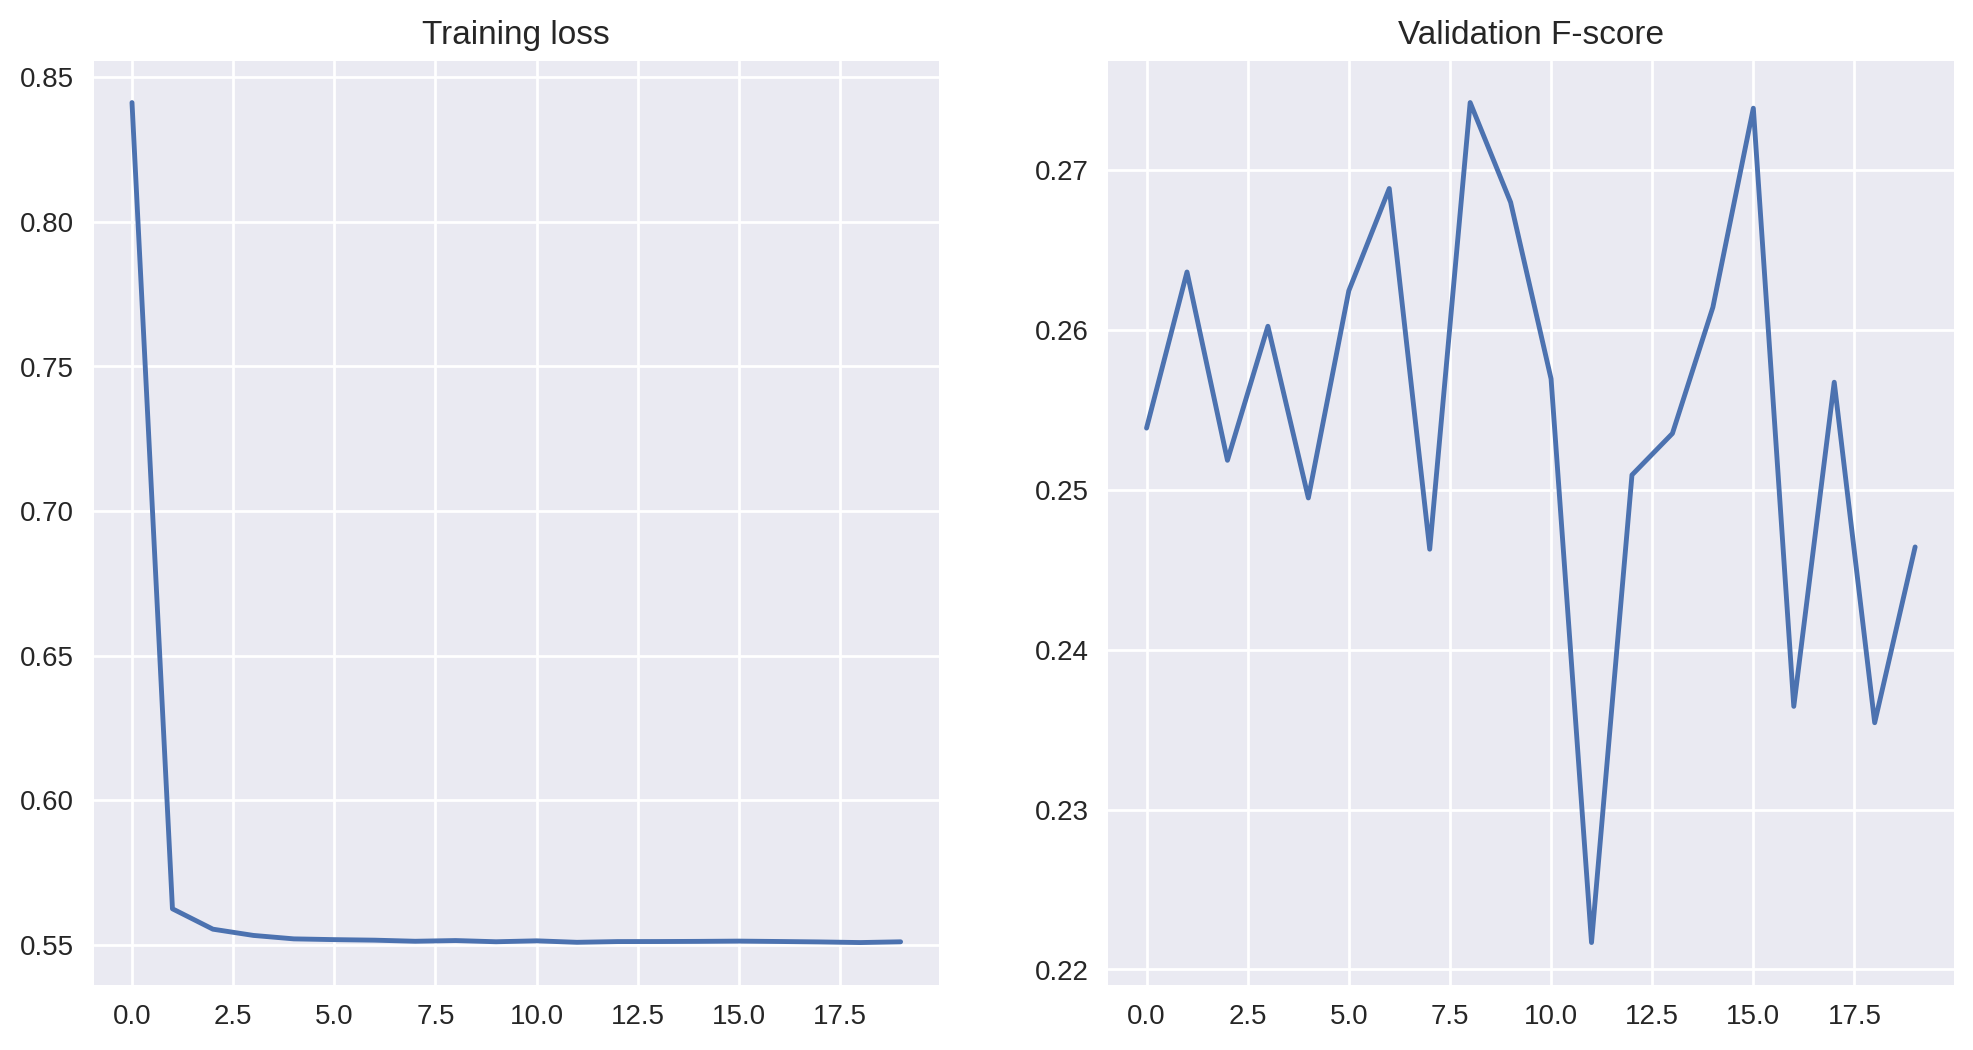

In [ ]:
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'
plt.style.use('seaborn')

fig, ax = plt.subplots(1, 2, figsize=(2*6,1*6))
ax[0].plot(ner_system.history['train_loss']);
ax[0].set_title('Training loss')
ax[1].plot(ner_system.history['val_f1']);
ax[1].set_title('Validation F-score')

Predicting outputs:

In [ ]:
tokens = 'The patient suffered from bubonic plague and COVID-19 .'.split()
ner_system.predict([tokens])


[['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']]

In [ ]:
scrip_NER_NLP_project.show_entities(ner_system, [tokens])

### 1. Adding an RNN to the sentence encoder

In [ ]:
import torch
from torch import nn

class LTSMModel(nn.Module):

    def __init__(self, seq_labeler):
        super().__init__()
        p = seq_labeler.params
        self.word_embedding = seq_labeler.word_voc.make_embedding_layer(finetune=p.finetune_word_emb,
                                                                        emb_dim=p.word_emb_dim)
        word_emb_dim = self.word_embedding.weight.shape[1]
        self.ltsm = nn.LSTM(input_size=word_emb_dim, hidden_size=64,
                           num_layers=2, batch_first=True,
                           bidirectional=True)
        self.top_layer = nn.Linear(128, seq_labeler.n_labels)

    def forward(self, words):
        word_repr = self.word_embedding(words)

        x, _ = self.ltsm(word_repr)
        return self.top_layer(x)

In [ ]:
ner_system = scrip_NER_NLP_project.SequenceLabeler(NERParameters(), LTSMModel)
ner_system.fit(Xtrain, Ytrain, Xval, Yval)

Epoch 1: train loss = 0.2275, val f1: 0.7573, time = 12.9343
Epoch 2: train loss = 0.1186, val f1: 0.7713, time = 13.8695
Epoch 3: train loss = 0.0982, val f1: 0.7806, time = 12.8019
Epoch 4: train loss = 0.0865, val f1: 0.7815, time = 13.4534
Epoch 5: train loss = 0.0780, val f1: 0.7759, time = 12.8688
Epoch 6: train loss = 0.0722, val f1: 0.7815, time = 12.8453
Epoch 7: train loss = 0.0665, val f1: 0.7769, time = 12.8545
Epoch 8: train loss = 0.0627, val f1: 0.7807, time = 12.8444
Epoch 9: train loss = 0.0586, val f1: 0.7820, time = 12.8636
Epoch 10: train loss = 0.0555, val f1: 0.7783, time = 12.7935
Epoch 11: train loss = 0.0531, val f1: 0.7857, time = 12.9863
Epoch 12: train loss = 0.0509, val f1: 0.7759, time = 12.7945
Epoch 13: train loss = 0.0491, val f1: 0.7759, time = 12.9137
Epoch 14: train loss = 0.0475, val f1: 0.7755, time = 12.9658
Epoch 15: train loss = 0.0463, val f1: 0.7727, time = 12.8149
Epoch 16: train loss = 0.0447, val f1: 0.7727, time = 12.9344
Epoch 17: train l

0.785680534617375

### 2. Investigating the word embedding model

In [ ]:
def f1_score_over_5_runs(ner_system):
  f1_scores = list()
  for i in range(5):
    f1 = ner_system.fit(Xtrain, Ytrain, Xval, Yval)
    ner_system.params.random_seed += 1
    f1_scores.append(f1)
  average_f1_score = sum(f1_scores)/5
  print('Average F1-Score: %s' % average_f1_score)
  return average_f1_score

In [ ]:
ner_system = scrip_NER_NLP_project.SequenceLabeler(NERParameters(), LTSMModel)
lstm = f1_score_over_5_runs(ner_system)

Epoch 1: train loss = 0.2275, val f1: 0.7572, time = 13.1233
Epoch 2: train loss = 0.1187, val f1: 0.7699, time = 12.7881
Epoch 3: train loss = 0.0986, val f1: 0.7809, time = 12.9170
Epoch 4: train loss = 0.0870, val f1: 0.7814, time = 12.8984
Epoch 5: train loss = 0.0780, val f1: 0.7835, time = 13.1534
Epoch 6: train loss = 0.0711, val f1: 0.7792, time = 13.4271
Epoch 7: train loss = 0.0670, val f1: 0.7814, time = 13.4152
Epoch 8: train loss = 0.0621, val f1: 0.7785, time = 12.8627
Epoch 9: train loss = 0.0583, val f1: 0.7830, time = 12.8568
Epoch 10: train loss = 0.0565, val f1: 0.7754, time = 12.8136
Epoch 11: train loss = 0.0533, val f1: 0.7809, time = 12.8150
Epoch 12: train loss = 0.0505, val f1: 0.7807, time = 12.9224
Epoch 13: train loss = 0.0486, val f1: 0.7776, time = 12.8922
Epoch 14: train loss = 0.0469, val f1: 0.7762, time = 12.8961
Epoch 15: train loss = 0.0463, val f1: 0.7742, time = 13.0015
Epoch 16: train loss = 0.0443, val f1: 0.7804, time = 12.8858
Epoch 17: train l

In [ ]:
ner_system = scrip_NER_NLP_project.SequenceLabeler(NERParameters(), LTSMModel)
ner_system.params.finetune_word_emb = True
lstm_finetuned = f1_score_over_5_runs(ner_system)

Epoch 1: train loss = 0.1920, val f1: 0.7920, time = 13.2808
Epoch 2: train loss = 0.0821, val f1: 0.8013, time = 13.3140
Epoch 3: train loss = 0.0600, val f1: 0.8002, time = 13.2791
Epoch 4: train loss = 0.0480, val f1: 0.8022, time = 13.2653
Epoch 5: train loss = 0.0400, val f1: 0.7932, time = 13.2319
Epoch 6: train loss = 0.0340, val f1: 0.7906, time = 13.2678
Epoch 7: train loss = 0.0291, val f1: 0.7929, time = 13.2237
Epoch 8: train loss = 0.0264, val f1: 0.7914, time = 13.2762
Epoch 9: train loss = 0.0240, val f1: 0.7930, time = 13.3503
Epoch 10: train loss = 0.0221, val f1: 0.7888, time = 13.3487
Epoch 11: train loss = 0.0208, val f1: 0.7862, time = 13.2756
Epoch 12: train loss = 0.0195, val f1: 0.7860, time = 13.2225
Epoch 13: train loss = 0.0183, val f1: 0.7884, time = 13.2597
Epoch 14: train loss = 0.0180, val f1: 0.7827, time = 13.1814
Epoch 15: train loss = 0.0173, val f1: 0.7887, time = 13.3031
Epoch 16: train loss = 0.0160, val f1: 0.7894, time = 13.3188
Epoch 17: train l

In [ ]:
glove_model = scrip_NER_NLP_project.load_gensim_vectors(model_file='glove-wiki-gigaword-100', builtin=True)

[==================================================] 100.0% 128.1/128.1MB downloaded
 done!


In [ ]:
ner_system = scrip_NER_NLP_project.SequenceLabeler(NERParameters(), LTSMModel, pretrained_word_emb=glove_model)
lstm_glove = f1_score_over_5_runs(ner_system)

Epoch 1: train loss = 0.1901, val f1: 0.7729, time = 12.8324
Epoch 2: train loss = 0.1122, val f1: 0.7979, time = 12.8844
Epoch 3: train loss = 0.0990, val f1: 0.8040, time = 12.9351
Epoch 4: train loss = 0.0897, val f1: 0.8106, time = 12.9623
Epoch 5: train loss = 0.0819, val f1: 0.8048, time = 12.8846
Epoch 6: train loss = 0.0757, val f1: 0.8069, time = 12.8840
Epoch 7: train loss = 0.0696, val f1: 0.8049, time = 12.9837
Epoch 8: train loss = 0.0651, val f1: 0.8031, time = 13.0783
Epoch 9: train loss = 0.0611, val f1: 0.8034, time = 12.8863
Epoch 10: train loss = 0.0571, val f1: 0.8022, time = 12.8897
Epoch 11: train loss = 0.0543, val f1: 0.8013, time = 12.8794
Epoch 12: train loss = 0.0521, val f1: 0.7986, time = 12.9418
Epoch 13: train loss = 0.0497, val f1: 0.7989, time = 12.8599
Epoch 14: train loss = 0.0471, val f1: 0.7966, time = 13.0500
Epoch 15: train loss = 0.0456, val f1: 0.7989, time = 13.0727
Epoch 16: train loss = 0.0441, val f1: 0.7926, time = 12.8974
Epoch 17: train l

In [ ]:
ner_system = scrip_NER_NLP_project.SequenceLabeler(NERParameters(), LTSMModel, pretrained_word_emb=glove_model)
ner_system.params.finetune_word_emb = True
lstm_glove_finetuned = f1_score_over_5_runs(ner_system)

Epoch 1: train loss = 0.1684, val f1: 0.7928, time = 30.6949
Epoch 2: train loss = 0.0905, val f1: 0.8083, time = 30.5967
Epoch 3: train loss = 0.0715, val f1: 0.8048, time = 30.3848
Epoch 4: train loss = 0.0590, val f1: 0.8002, time = 31.0953
Epoch 5: train loss = 0.0495, val f1: 0.7998, time = 30.5529
Epoch 6: train loss = 0.0427, val f1: 0.8013, time = 30.3741
Epoch 7: train loss = 0.0365, val f1: 0.7899, time = 31.2002
Epoch 8: train loss = 0.0322, val f1: 0.7922, time = 30.3913
Epoch 9: train loss = 0.0289, val f1: 0.7885, time = 30.4849
Epoch 10: train loss = 0.0259, val f1: 0.7832, time = 30.8069
Epoch 11: train loss = 0.0240, val f1: 0.7897, time = 30.3779
Epoch 12: train loss = 0.0222, val f1: 0.7875, time = 30.4046
Epoch 13: train loss = 0.0206, val f1: 0.7861, time = 30.7892
Epoch 14: train loss = 0.0188, val f1: 0.7780, time = 30.4121
Epoch 15: train loss = 0.0184, val f1: 0.7804, time = 30.6793
Epoch 16: train loss = 0.0181, val f1: 0.7773, time = 30.6906
Epoch 17: train l

### BERT-Model:

In [ ]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import BertModel
import torch.nn as nn

class BertForNER(nn.Module):
    def init(self, bert_model_name, num_labels):
        super(BertForNER, self).init()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask=None):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        sequence_output = outputs[0]
        logits = self.classifier(sequence_output)
        return logits

def model_factory(sequence_labeler):
    # 'sequence_labeler' is an instance of the SequenceLabeler class
    bert_model_name = 'distilbert-base-uncased'  # or 'distilbert-base-uncased' for DistilBERT
    num_labels = len(sequence_labeler.label_voc)
    # Create and return the model
    return BertForNER(bert_model_name, num_labels)

    params = NERParameters()  # Define your NER parameters
    params.bert_max_len = 128
    params.use_characters = False

    distil_bert = AutoTokenizer.from_pretrained('distilbert-base-uncased')
    # Initialize the SequenceLabeler
    ner_system = SequenceLabeler(params, model_factory, bert_tokenizer=distil_bert)


In [ ]:
# Now you can preprocess your data and fit the model
ner_system.fit(Xtrain, Ytrain, Xval, Yval)

Epoch 1: train loss = 0.1692, val f1: 0.8001, time = 30.5404
Epoch 2: train loss = 0.0904, val f1: 0.8077, time = 31.3266
Epoch 3: train loss = 0.0713, val f1: 0.8052, time = 30.6119
Epoch 4: train loss = 0.0587, val f1: 0.7994, time = 30.4817
Epoch 5: train loss = 0.0489, val f1: 0.7977, time = 31.1200
Epoch 6: train loss = 0.0415, val f1: 0.7948, time = 30.5236
Epoch 7: train loss = 0.0359, val f1: 0.7959, time = 30.4470
Epoch 8: train loss = 0.0320, val f1: 0.7938, time = 30.9244
Epoch 9: train loss = 0.0283, val f1: 0.7945, time = 30.4910
Epoch 10: train loss = 0.0250, val f1: 0.7924, time = 31.0107
Epoch 11: train loss = 0.0231, val f1: 0.7887, time = 30.7244
Epoch 12: train loss = 0.0222, val f1: 0.7845, time = 30.4879
Epoch 13: train loss = 0.0200, val f1: 0.7889, time = 31.3423
Epoch 14: train loss = 0.0188, val f1: 0.7838, time = 30.6923
Epoch 15: train loss = 0.0171, val f1: 0.7841, time = 30.5762
Epoch 16: train loss = 0.0172, val f1: 0.7831, time = 30.8226
Epoch 17: train l

0.8077295120689267

In [ ]:
def train_and_evaluate(ner_system, X_train, Y_train, X_val, Y_val, num_runs, finetune_emb=False):
    ner_system.params.finetune_word_emb = finetune_emb
    f1_scores = []
    for i in range(num_runs):
        # Set a different random seed each time
        ner_system.params.random_seed = i
        # Train the system
        ner_system.preprocess(X_train, Y_train, X_val, Y_val)

        f1_score = ner_system.fit(X_train, Y_train, X_val, Y_val)
        f1_scores.append(f1_score)
    return f1_scores

f1_scores_frozen = train_and_evaluate(ner_system, Xtrain, Ytrain, Xval, Yval, num_runs=5, finetune_emb=False)
mean_f1_frozen = sum(f1_scores_frozen) / len(f1_scores_frozen)

Epoch 1: train loss = 0.1901, val f1: 0.7741, time = 14.3991
Epoch 2: train loss = 0.1122, val f1: 0.7987, time = 14.6317
Epoch 3: train loss = 0.0990, val f1: 0.8055, time = 14.0753
Epoch 4: train loss = 0.0896, val f1: 0.8053, time = 13.3355
Epoch 5: train loss = 0.0820, val f1: 0.8019, time = 13.0817
Epoch 6: train loss = 0.0755, val f1: 0.8013, time = 13.3604
Epoch 7: train loss = 0.0699, val f1: 0.8069, time = 13.4723
Epoch 8: train loss = 0.0649, val f1: 0.8028, time = 13.2936
Epoch 9: train loss = 0.0611, val f1: 0.7998, time = 13.2037
Epoch 10: train loss = 0.0577, val f1: 0.8007, time = 13.3242
Epoch 11: train loss = 0.0548, val f1: 0.7966, time = 13.2445
Epoch 12: train loss = 0.0518, val f1: 0.7976, time = 13.1379
Epoch 13: train loss = 0.0489, val f1: 0.7981, time = 13.0948
Epoch 14: train loss = 0.0470, val f1: 0.7937, time = 13.1688
Epoch 15: train loss = 0.0457, val f1: 0.7926, time = 13.3358
Epoch 16: train loss = 0.0445, val f1: 0.7891, time = 13.1048
Epoch 17: train l




### ELMo-Model

In [ ]:
import pandas as pd
import zipfile
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils import rnn
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from torch.nn import functional as F
import nltk

In [ ]:
# Download the raw files from GitHub

!wget https://github.com/richi1998/NLP-Project/raw/main/ner_dataset.csv.zip -O ner_dataset.csv.zip


with zipfile.ZipFile('ner_dataset.csv.zip', 'r') as zip_ref:
    zip_ref.extractall()

# Check what files are in the directory
print("Files in the current directory:", os.listdir())

--2024-01-07 19:52:17--  https://github.com/richi1998/NLP-Project/raw/main/ner_dataset.csv.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/richi1998/NLP-Project/main/ner_dataset.csv.zip [following]
--2024-01-07 19:52:17--  https://raw.githubusercontent.com/richi1998/NLP-Project/main/ner_dataset.csv.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3319491 (3.2M) [application/zip]
Saving to: ‘ner_dataset.csv.zip’

ner_dataset.csv.zip 100%[===================>]   3.17M  --.-KB/s    in 0.04s   

2024-01-07 19:52:18 (74.9 MB/s) - ‘ner_dataset.csv.zip’ saved [3319491/3319491]

Files in the curr

In [ ]:
# Read the CSV files

df2 = pd.read_csv('ner_dataset.csv', encoding='latin1')  # Adjust encoding if necessary
df2 = df2.fillna(method='ffill')

In [ ]:
# Instantiate ELMo model
from allennlp.modules.elmo import Elmo
options_file = "https://allennlp.s3.amazonaws.com/models/elmo/2x4096_512_2048cnn_2xhighway/elmo_2x4096_512_2048cnn_2xhighway_options.json"
weight_file = "https://allennlp.s3.amazonaws.com/models/elmo/2x4096_512_2048cnn_2xhighway/elmo_2x4096_512_2048cnn_2xhighway_weights.hdf5"
elmo = Elmo(options_file, weight_file, num_output_representations=1, dropout=0)

/usr/local/lib/python3.10/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /usr/local/lib/python3.10/dist-packages/torchvision/image.so: undefined symbol: _ZN3c104cuda20CUDACachingAllocator12recordStreamERKNS_7DataPtrENS0_10CUDAStreamE
  warn(f"Failed to load image Python extension: {e}")


Output()

Output()

In [ ]:
def get_sentences_and_labels(df):
    agg_func = lambda s: [(w, t) for w, t in zip(s['Word'].values.tolist(),
                                                  s['Tag'].values.tolist())]
    grouped_df = df.groupby('Sentence #').apply(agg_func)
    sentences = [[word_label[0] for word_label in sentence] for sentence in grouped_df]
    labels = [[word_label[1] for word_label in sentence] for sentence in grouped_df]
    return sentences, labels

sentences, label_sentences = get_sentences_and_labels(df2)

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit([label for sublist in label_sentences for label in sublist])
encoded_labels = [label_encoder.transform(label_list) for label_list in label_sentences]
unique_labels = set(tag for label_list in label_sentences for tag in label_list)
tag2idx = {tag: idx for idx, tag in enumerate(unique_labels)}
# Add the padding token to your set of unique labels
unique_labels.add("<PAD>")

# Create the label-to-index mapping
tag2idx = {tag: idx for idx, tag in enumerate(unique_labels)}

# Define the index for the padding label
label_pad_index = tag2idx["<PAD>"]

In [ ]:
train_sentences, test_sentences, train_labels, test_labels = train_test_split(sentences, encoded_labels, test_size=0.2)


In [ ]:
# Checking the first few sentences and labels in the training set
for i in range(1):
    print("Training Sentence:", train_sentences[i])
    print("Training Labels:", train_labels[i])
print(len(tag2idx))

Training Sentence: ['Russian', 'Prosecutor', 'General', 'Yuri', 'Chaika', 'Monday', 'announced', 'the', 'arrest', 'of', '10', 'people', 'in', 'the', 'case', '.']
Training Labels: [ 3  5 13 13 13  7 16 16 16 16 16 16 16 16 16 16]
18


In [ ]:
class NERDataset(Dataset):
    def __init__(self, sentences, labels):
        self.sentences = sentences
        self.labels = labels

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        # ELMO handles conversion of sentences to character IDs, so we keep sentences as they are
        return {
            'sentence': self.sentences[idx],  # List of words
            'label': torch.tensor(self.labels[idx], dtype=torch.long)
        }

In [ ]:
def collate_fn(batch):
    sentences = [item['sentence'] for item in batch]
    labels = [item['label'] for item in batch]

    sentences = batch_to_ids(sentences)  # Convert sentences to ELMO character IDs
    labels = torch.nn.utils.rnn.pad_sequence(labels, batch_first=True, padding_value=label_pad_index)

    return sentences, labels

train_dataset = NERDataset(train_sentences, train_labels)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_dataset = NERDataset(test_sentences, test_labels)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

In [ ]:
# MODEL
class NERModel(nn.Module):
    def __init__(self, elmo, hidden_dim, num_labels):
        super(NERModel, self).__init__()
        self.elmo = elmo
        self.lstm = nn.LSTM(input_size=elmo.get_output_dim(),
                            hidden_size=hidden_dim,
                            batch_first=True,
                            bidirectional=True)
        self.hidden2tag = nn.Linear(hidden_dim * 2, num_labels)

    def forward(self, x):
        # x is a batch of sentences with each sentence as a list of character ids

        # Create ELMo embeddings
        embeddings = self.elmo(x)['elmo_representations'][0]

        # Pass embeddings through LSTM
        lstm_out, _ = self.lstm(embeddings)

        # Fully connected layer
        tag_space = self.hidden2tag(lstm_out)
        tag_scores = torch.nn.functional.log_softmax(tag_space, dim=1)
        return tag_scores

# Initialize the model
model = NERModel(elmo, hidden_dim=256, num_labels=len(tag2idx))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

NERModel(
  (elmo): Elmo(
    (_elmo_lstm): _ElmoBiLm(
      (_token_embedder): _ElmoCharacterEncoder(
        (char_conv_0): Conv1d(16, 32, kernel_size=(1,), stride=(1,))
        (char_conv_1): Conv1d(16, 32, kernel_size=(2,), stride=(1,))
        (char_conv_2): Conv1d(16, 64, kernel_size=(3,), stride=(1,))
        (char_conv_3): Conv1d(16, 128, kernel_size=(4,), stride=(1,))
        (char_conv_4): Conv1d(16, 256, kernel_size=(5,), stride=(1,))
        (char_conv_5): Conv1d(16, 512, kernel_size=(6,), stride=(1,))
        (char_conv_6): Conv1d(16, 1024, kernel_size=(7,), stride=(1,))
        (_highways): Highway(
          (_layers): ModuleList(
            (0-1): 2 x Linear(in_features=2048, out_features=4096, bias=True)
          )
        )
        (_projection): Linear(in_features=2048, out_features=512, bias=True)
      )
      (_elmo_lstm): ElmoLstm(
        (forward_layer_0): LstmCellWithProjection(
          (input_linearity): Linear(in_features=512, out_features=16384, bias=Fa

In [ ]:
from allennlp.modules.elmo import batch_to_ids


# Checking data loading and preprocessing
for sentences, labels in train_loader:
    print("Sample sentences:", sentences)
    print("Sample labels:", labels)
    break  # Only check the first batch

# Checkiing data shapes and types
print("Shape of sentences:", sentences.shape)
print("Shape of labels:", labels.shape)
print("Data type of sentences:", sentences.dtype)
print("Data type of labels:", labels.dtype)

# Testing a dummy batch through the model
try:
    with torch.no_grad():
        output = model(sentences)
    print("Dummy batch successfully processed by the model.")
except Exception as e:
    print("Error processing dummy batch:", e)


Sample sentences: tensor([[[259,  85, 105,  ..., 261, 261, 261],
         [259,  86,  47,  ..., 261, 261, 261],
         [259, 103, 112,  ..., 261, 261, 261],
         ...,
         [  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0]],

        [[259,  67, 118,  ..., 261, 261, 261],
         [259, 113, 115,  ..., 261, 261, 261],
         [259, 109, 102,  ..., 261, 261, 261],
         ...,
         [  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0]],

        [[259,  80, 111,  ..., 261, 261, 261],
         [259,  85, 118,  ..., 261, 261, 261],
         [259,  45, 260,  ..., 261, 261, 261],
         ...,
         [  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0]],

        ...,

        [[259,  81,  98,  ..., 261, 261, 261],
         [259,  74, 111,  .

In [ ]:
from torch.utils.data import Subset, DataLoader
import numpy as np
from tqdm import tqdm
import torch
from torch.optim import Adam
from torch.nn import CrossEntropyLoss

train_dataset = NERDataset(train_sentences, train_labels)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

# Define the loss function and optimizer
# Here we specify to ignore the padding index in the loss computation
criterion = CrossEntropyLoss(ignore_index=label_pad_index)
optimizer = Adam(model.parameters(), lr=0.001)

# Number of training epochs
num_epochs = 1
num_labels = len(tag2idx)

# Early stopping parameters
best_loss = float('inf')
epochs_no_improve = 0
n_epochs_stop = 5

# Training loop with early stopping
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}')

    for sentences, labels in progress_bar:
        sentences = sentences.to(device)  # Move sentences to the device
        labels = labels.to(device)  # Move labels to the device

        labels = labels.view(-1)  # Flatten labels

        tag_scores = model(sentences)
        tag_scores = tag_scores.view(-1, num_labels)

        loss = criterion(tag_scores, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        progress_bar.set_postfix({'batch_loss': loss.item()})

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Average Loss: {avg_loss:.4f}")

    # Early stopping check
    if avg_loss < best_loss:
        best_loss = avg_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve == n_epochs_stop:
            print('Early stopping triggered')
            break


ModuleNotFoundError: No module named 'torch._dynamo'

In [ ]:
def evaluate_model(model, test_loader, device, pad_token_index):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for sentences, labels in test_loader:
            sentences = sentences.to(device)
            labels = labels.to(device)
            labels_flattened = labels.view(-1)  # Flatten labels

            outputs = model(sentences)
            outputs = outputs.view(-1, num_labels)

            # Exclude padding tokens from predictions and true labels
            mask = labels_flattened != pad_token_index
            predictions = torch.argmax(outputs, dim=1)
            filtered_predictions = predictions[mask]
            filtered_labels = labels_flattened[mask]

            all_predictions.extend(filtered_predictions.cpu().numpy())
            all_labels.extend(filtered_labels.cpu().numpy())

            # Compute the loss only on non-padding tokens
            loss = criterion(outputs[mask], filtered_labels)
            total_loss += loss.item()

    avg_loss = total_loss / len(test_loader)
    print(f"Test Loss: {avg_loss:.4f}")
    return all_predictions, all_labels



In [ ]:
# Evaluate the model
predictions, true_labels = evaluate_model(model, test_loader, device, label_pad_index)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

# Assuming predictions and true_labels are already flattened as earlier

# Calculate overall accuracy
accuracy = accuracy_score(true_labels, predictions)
print(f"Overall Accuracy: {accuracy:.4f}")

# Generate a comprehensive classification report
report = classification_report(true_labels, predictions, zero_division=0)
print("Classification Report:\n", report)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Saving the model to Google Drive
torch.save(model.state_dict(), '/content/NLP-Project/model_state_dict.pth')


In [ ]:
# from google.colab import files
# files.download('/content/NLP-Project/model_state_dict.pth')


In [ ]:
# # Loading the model state dictionary
# model.load_state_dict(torch.load('/content/NLP-Project/model_state_dict.pth'))
# model.eval()  # Setting the model to evaluation mode


### Investigating the dataset again







In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")


data = df2.drop(['POS'], axis =1) #dont need this part
data = data.fillna(method="ffill")


In [ ]:
'''
geo = Geographical Entity
org = Organization
per = Person
gpe = Geopolitical Entity
tim = Time indicator
art = Artifact
eve = Event
nat = Natural Phenomenon
'''
data['Tag'].value_counts()

In [ ]:
class SentenceGetter(object):

    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(),s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [ ]:
getter = SentenceGetter(data)
sent = getter.get_next()
for i in sent:
  print(i)

In [ ]:
sentences = getter.sentences
print(len(sentences))

In [ ]:
largest_sen = max(len(sen) for sen in sentences)
print('biggest sentence has {} words'.format(largest_sen))

In [ ]:
%matplotlib inline
plt.hist([len(sen) for sen in sentences], bins= 50)
plt.show()

In [ ]:
sentences = getter.sentences

# Find sentences longer than 60 words
long_sentences = [sen for sen in sentences if len(sen) > 80]

# Print the count and the actual sentences
print("Number of sentences longer than 80 words:", len(long_sentences))
for idx, sen in enumerate(long_sentences, 1):
    print(f"Sentence {idx}: {sen}")
